# Data Visualisation (of prepared ICU stay data and final model)

In [1]:
# load packages
import pandas as pd
import numpy as np
import os
import datetime as dt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
from sklearn import preprocessing
from utils import *
import pickle
import statsmodels.formula.api as smf
from jupyterthemes import jtplot

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

## Data Visualisation of Prepared ICU stay data

In [2]:
# Raw tables
# data file locations
FILE_PATH = '0_raw_data/'
FILE_EXTENSION = '.csv'
INPUT_DATA_DIR = '1_input/input.csv'
STARTING_TABLES  = \
['pt_icu_outcome', 'vitals_hourly', 'labs_hourly', 
 'gcs_hourly', 'admissions', 'patients']
FILE_DIR = [FILE_PATH + name + FILE_EXTENSION for name in STARTING_TABLES]

# data ingestion
raw_icu = pd.read_csv(FILE_DIR[0])
raw_vitals = pd.read_csv(FILE_DIR[1])
raw_labs = pd.read_csv(FILE_DIR[2])
raw_gcs = pd.read_csv(FILE_DIR[3]) #Glasgow Coma Score
raw_ad = pd.read_csv(FILE_DIR[4])
raw_patients = pd.read_csv(FILE_DIR[5])
df = pd.read_pickle("1_input/input_viz.pkl")

In [3]:
df.columns

Index(['row_id', 'subject_id', 'dob', 'hadm_id', 'admittime', 'dischtime',
       'icustay_id', 'age_years', 'intime', 'outtime', 'los', 'hosp_deathtime',
       'icu_expire_flag', 'hospital_expire_flag', 'dod', 'expire_flag',
       'ttd_days', 'age_bins', 'intime_weekday', 'icu_adm_weekend', 'ttd_bins',
       'standard_mortality_label', 'gender', 'dod_hosp', 'dod_ssn',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'has_chartevents_data', 'prev_dischtime', 'tt_next_adm_days',
       're_adm_in30d', 'len_of_adm', 'english_speaker', 'bp_elevated',
       'bp_hbp_s1', 'bp_hbp_s2', 'bp_hyptsn_crisis', 'abnorm_spo2', 'fever',
       'tachycardia', 'bradycardia', 'diabetes', 'abnorm_map', 'endotrachflag',
       'eye_no_resp', 'motor_no_resp', 'verbal_no_resp', 'gcs_severe',
       'gcs_moderate', 'abnorm_albumin', 'abnorm_bilir

In [4]:
dataset_brief(raw_icu, 'icu')

Dataset icu provided of size:	61533 rows and 17 columns

List of columns in the dataset:
['row_id', 'subject_id', 'dob', 'hadm_id', 'admittime', 'dischtime', 'icustay_id', 'age_years', 'intime', 'outtime', 'los', 'hosp_deathtime', 'icu_expire_flag', 'hospital_expire_flag', 'dod', 'expire_flag', 'ttd_days']
over 50% values missing in following columns:
hosp_deathtime   0.96
ttd_days         0.61
dod              0.61
dtype: float64
Column row_id has 61532 unique values
Column subject_id has 46476 unique values
Column hadm_id has 57786 unique values
Column icustay_id has 61532 unique values


In [5]:
extracted_icu = raw_icu.query("intime.notnull() and outtime.notnull() and \
icustay_id!=229922 and (ttd_days >=0 or ttd_days.isnull())")
extracted_icu.ttd_days.notnull().value_counts(normalize=True)

False   0.61
True    0.39
Name: ttd_days, dtype: float64

In [6]:
ttd_x = raw_icu.query('intime.notnull() and outtime.notnull() and icustay_id!=229922 and (ttd_days >=0 or ttd_days.isnull())').ttd_days
ttd_x.describe()

count   24183.00
mean      503.88
std       752.40
min         0.00
25%        14.00
50%       132.00
75%       694.50
max      4332.00
Name: ttd_days, dtype: float64

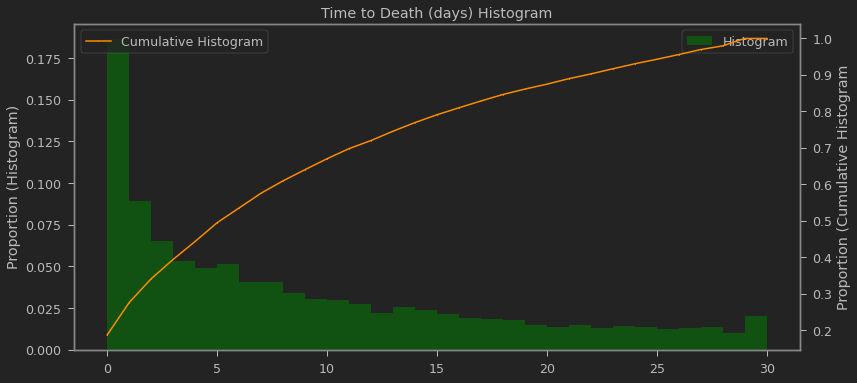

In [7]:
hist(ttd_x, bins=30, title="Time to Death (days) Histogram", range=(0,30))

In [8]:
dataset_brief(raw_patients, 'patients')

Dataset patients provided of size:	46520 rows and 8 columns

List of columns in the dataset:
['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag']
over 50% values missing in following columns:
dod_hosp   0.79
dod_ssn    0.71
dod        0.66
dtype: float64
Column row_id has 46520 unique values
Column subject_id has 46520 unique values


In [9]:
dataset_brief(raw_ad, 'admissions')

Dataset admissions provided of size:	58976 rows and 19 columns

List of columns in the dataset:
['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data']
over 50% values missing in following columns:
deathtime   0.90
dtype: float64
Column row_id has 58976 unique values
Column subject_id has 46520 unique values
Column hadm_id has 58976 unique values


In [10]:
raw_ad.insurance.value_counts(normalize=True, dropna=False)

Medicare     0.48
Private      0.38
Medicaid     0.10
Government   0.03
Self Pay     0.01
Name: insurance, dtype: float64

In [11]:
dataset_brief(raw_vitals, 'vitals - bedside measurements')

Dataset vitals - bedside measurements provided of size:	7292362 rows and 11 columns

List of columns in the dataset:
['icustay_id', 'hr', 'spo2', 'fio2', 'temperature', 'resprate', 'heartrate', 'sysbp', 'diasbp', 'glucose', 'meanarterialpressure']
over 50% values missing in following columns:
fio2          0.87
glucose       0.84
temperature   0.79
dtype: float64
Column icustay_id has 61522 unique values


In [12]:
raw_vitals.describe()

,icustay_id,hr,spo2,fio2,temperature,resprate,heartrate,sysbp,diasbp,glucose,meanarterialpressure
count,7292362.00,7292362.00,5319977.00,950397.00,1565924.00,4742189.00,6420350.00,4644472.00,4643694.00,1148019.00,4660544.00
mean,250001.80,285.50,93.35,50.46,37.02,20.41,103.30,121.99,61.29,142.30,79.39
std,28683.96,444.04,3143.43,28.73,3.00,540.89,48.43,132.03,237.06,1320.91,97.55
min,200001.00,1.00,-34.00,21.00,-73.28,0.00,-88.00,-69.00,-4.00,0.11,-36.00
25%,225161.00,35.00,96.00,27.00,36.50,16.00,78.00,105.00,51.00,107.00,68.00
50%,250192.00,109.00,98.00,40.00,37.00,20.00,93.00,119.00,59.00,129.00,77.00
75%,274800.00,331.00,99.00,65.00,37.56,24.00,127.00,136.00,69.00,159.00,88.00
max,299999.00,4154.00,6363333.00,100.00,2686.31,1177786.50,86101.00,141146.04,114108.98,999999.00,120130.03


In [13]:
dataset_brief(raw_labs, 'labs')

Dataset labs provided of size:	928195 rows and 22 columns

List of columns in the dataset:
['icustay_id', 'hr', 'neutrophil', 'creactiveprotein', 'whitebloodcell', 'partialpressureo2', 'bicarbonate', 'lactate', 'troponin', 'bloodureanitrogen', 'creatinine', 'alaninetransaminase', 'aspartatetransaminase', 'hemoglobin', 'intnormalisedratio', 'platelets', 'albumin', 'chloride', 'glucose', 'sodium', 'bilirubin', 'hematocrit']
over 50% values missing in following columns:
creactiveprotein        1.00
troponin                0.96
albumin                 0.93
neutrophil              0.92
aspartatetransaminase   0.90
alaninetransaminase     0.90
bilirubin               0.88
lactate                 0.82
intnormalisedratio      0.73
whitebloodcell          0.62
platelets               0.60
bloodureanitrogen       0.59
creatinine              0.59
bicarbonate             0.58
sodium                  0.56
hemoglobin              0.55
chloride                0.53
hematocrit              0.53
partia

In [14]:
dataset_brief(raw_gcs, 'GCSs')

Dataset GCSs provided of size:	1515342 rows and 7 columns

List of columns in the dataset:
['icustay_id', 'hr', 'gcs', 'gcseyes', 'gcsmotor', 'gcsverbal', 'endotrachflag']
over 50% values missing in following columns:
Series([], dtype: float64)
Column icustay_id has 52355 unique values


In [15]:
df = pd.read_pickle("1_input/input_rq1.pkl")
TARGETS = ['standard_mortality_label']
labels = [False, True]
dataset_brief(df, 'Final Table for Research Question 1')

Dataset Final Table for Research Question 1 provided of size:	51065 rows and 62 columns

List of columns in the dataset:
['los', 'standard_mortality_label', 'age_bins_under44', 'age_bins_45-54', 'age_bins_55-64', 'age_bins_65-74', 'age_bins_over75', 'intime_weekday_Friday', 'intime_weekday_Monday', 'intime_weekday_Saturday', 'intime_weekday_Sunday', 'intime_weekday_Thursday', 'intime_weekday_Tuesday', 'intime_weekday_Wednesday', 'gender_M', 'len_of_adm', 're_adm_in30d_True', 'english_speaker_True', 'insure_government', 'insure_medicaid', 'insure_medicare', 'insure_private', 'insure_selfpay', 'adm_type_elective', 'adm_type_emergency', 'adm_type_urgent', 'bp_elevated', 'bp_hbp_s1', 'bp_hbp_s2', 'bp_hyptsn_crisis', 'abnorm_spo2', 'fever', 'tachycardia', 'bradycardia', 'diabetes', 'abnorm_map', 'endotrachflag', 'eye_no_resp', 'motor_no_resp', 'verbal_no_resp', 'gcs_severe', 'gcs_moderate', 'abnorm_albumin', 'abnorm_bilirubin', 'abnorm_alt', 'abnorm_ast', 'abnorm_hemoglobin', 'abnorm_hemato

In [16]:
dataset_brief(raw_icu, 'icu')

Dataset icu provided of size:	61533 rows and 17 columns

List of columns in the dataset:
['row_id', 'subject_id', 'dob', 'hadm_id', 'admittime', 'dischtime', 'icustay_id', 'age_years', 'intime', 'outtime', 'los', 'hosp_deathtime', 'icu_expire_flag', 'hospital_expire_flag', 'dod', 'expire_flag', 'ttd_days']
over 50% values missing in following columns:
hosp_deathtime   0.96
ttd_days         0.61
dod              0.61
dtype: float64
Column row_id has 61532 unique values
Column subject_id has 46476 unique values
Column hadm_id has 57786 unique values
Column icustay_id has 61532 unique values


In [17]:
# Split prepared data into feature set and target/label set
df0 = df.copy()
df0 = df0.rename(columns={'standard_mortality_label':'ICU_Mortality'})
X = df0.drop(['ICU_Mortality'], axis=1) #feature set: drop outcome column
y = df0[['ICU_Mortality']] #target set: outcome column

x = X.nunique()
CATEGORICAL_4_VIZ = list(x[x==2].index) # categorical: non-outcome columns with 2 unique values (one-hot-encoding applied)
CONTINUOUS_4_VIZ = [x for x in df0.columns if x not in CATEGORICAL_4_VIZ] # other non-outcome columns

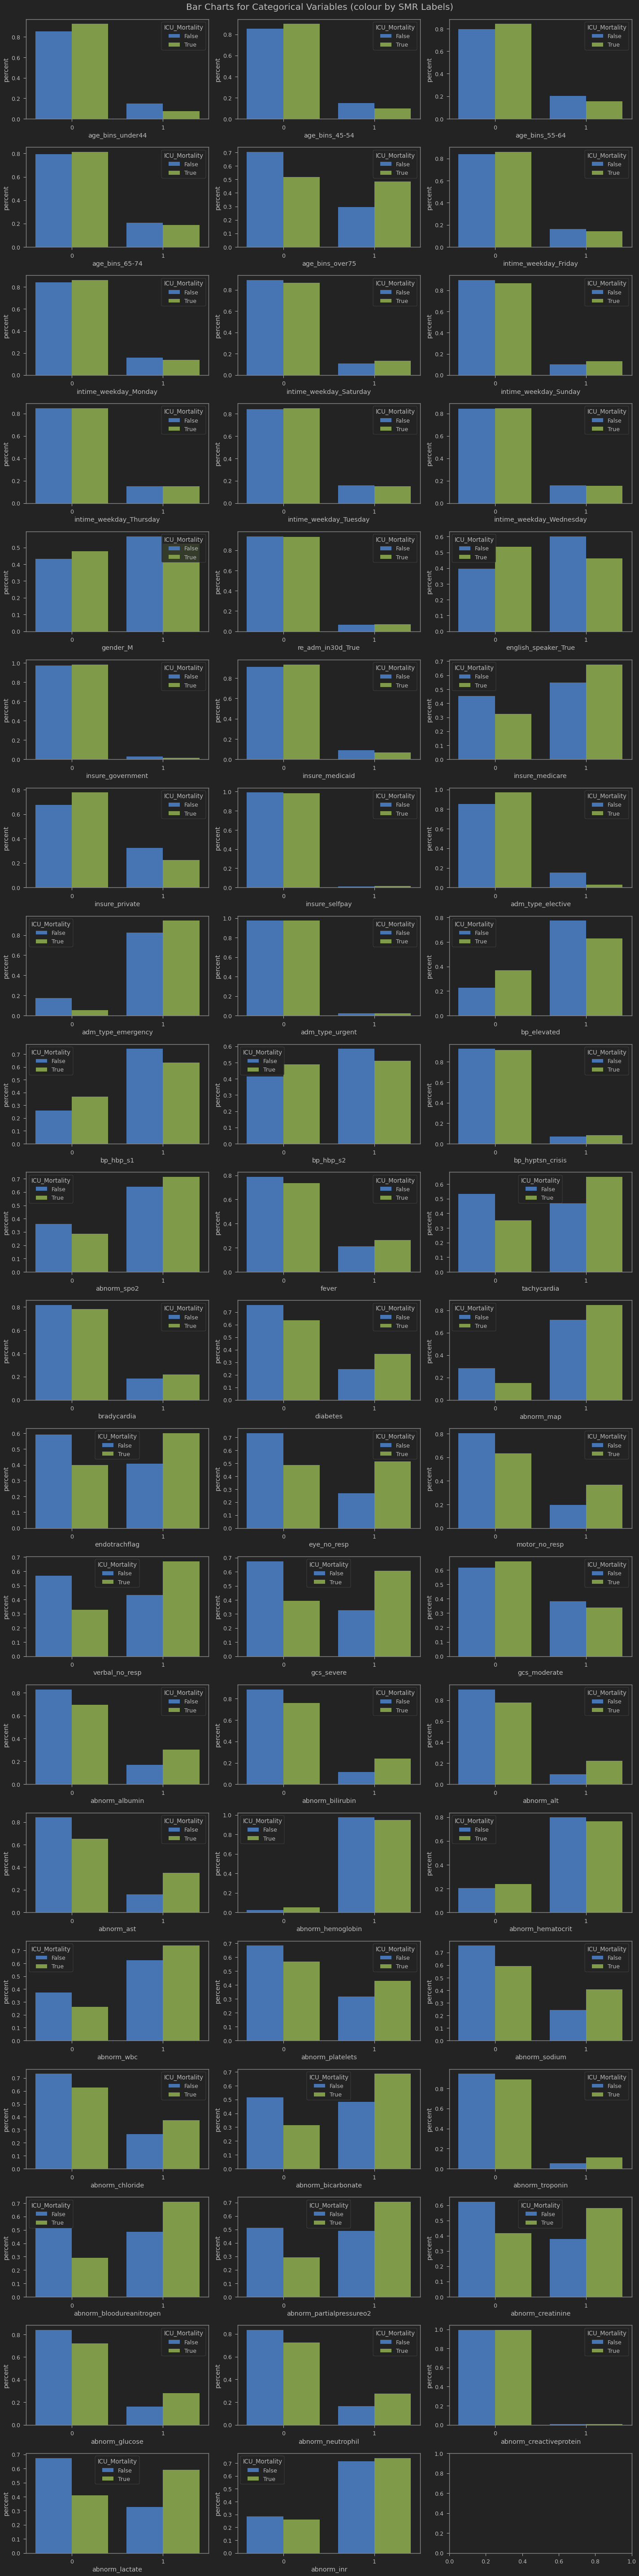

In [20]:
# Bar plots for categorical columns
fig, ax = plt.subplots(20, 3, figsize=(20, 80))
plt.suptitle('Bar Charts for Categorical Variables (colour by SMR Labels)',
             x=0.5, y=0.998, size=20)
# [2b] By percent
for variable, subplot in zip(CATEGORICAL_4_VIZ, ax.flatten()):
    pct2 = (df0.groupby([variable,'ICU_Mortality']).size() / \
            df0.groupby(['ICU_Mortality']).size()).reset_index().rename({0:'percent'}, axis=1)
    sns.barplot(x=variable, hue='ICU_Mortality', y='percent', data=pct2, ax=subplot)
plt.tight_layout()
plt.show()

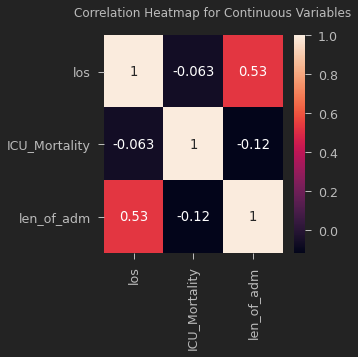

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
g = sns.heatmap(df0[CONTINUOUS_4_VIZ].corr(), annot=True, ax=ax)
plt.suptitle('Correlation Heatmap for Continuous Variables', 
             size=12)
plt.show()

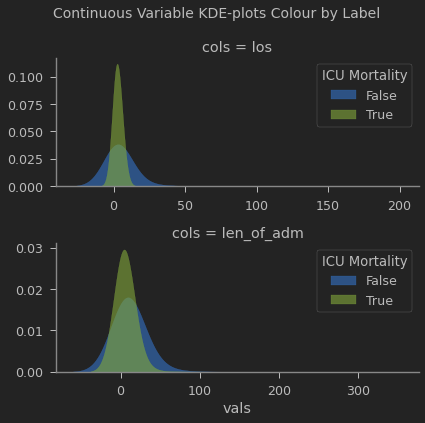

In [22]:
# KDF plots for continous variables
df_mel = pd.melt(df0[CONTINUOUS_4_VIZ], id_vars=['ICU_Mortality'],
                 var_name = 'cols',value_name= 'vals')
p = sns.FacetGrid(df_mel
                  , col = 'cols'
                  , hue = 'ICU_Mortality'
                  , col_wrap= 1
                  , sharex=False
                  , sharey=False
                  , margin_titles=True
                  , legend_out=True)
pg = (p.map(sns.kdeplot, "vals", alpha=0.6, shade=True, bw_method=1.5))
#pg = p.map(plt.hist, 'vals', alpha = 0.6).add_legend()
pg.fig.suptitle('Continuous Variable KDE-plots Colour by Label', size=14)
pg.fig.subplots_adjust(bottom=0.5)
pg.fig.set_size_inches(6,6)
for ax in pg.axes.ravel():
    ax.legend(title="ICU Mortality"
             , loc='upper right')
plt.tight_layout()
plt.show()

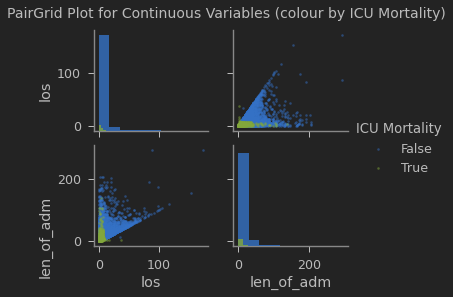

In [24]:
# Pair Plot for Multi-collinearity Check
p = sns.PairGrid(df0[CONTINUOUS_4_VIZ], hue = 'ICU_Mortality')
pg = p.map_diag(plt.hist, alpha = 0.8)
pg = pg.map_offdiag(plt.scatter, alpha = 0.5, s=5)
for ax in pg.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 0)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 90)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')
pg = pg.add_legend(loc=7, title="ICU Mortality")
pg.fig.suptitle('PairGrid Plot for Continuous Variables (colour by ICU Mortality)', size=14)
pg.fig.subplots_adjust(top=.9)
pg.fig.set_size_inches(6,4)
plt.show()

## Data visualisation of the final model

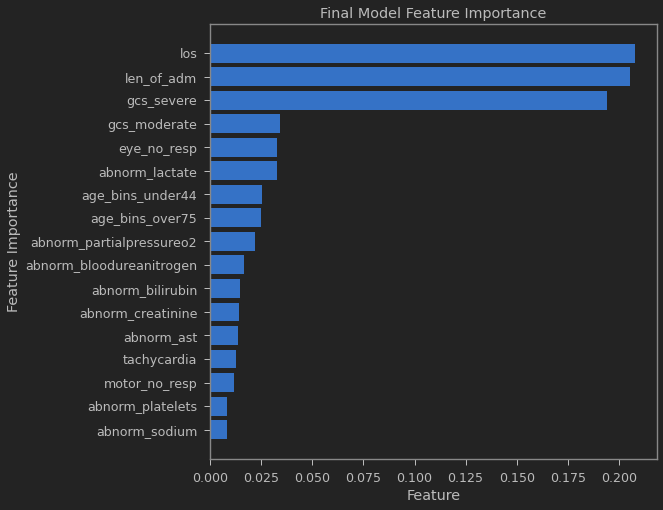

In [32]:
# load the model from disk
filename = 'final_model/gbt_model.pkl'
final_model = pickle.load(open(filename, 'rb'))
def plot_feature_importance(model):
    plt.rcParams["figure.figsize"] = (8,8)
    indices = np.argsort(model.feature_importances_)
    indices = indices[-17:]
    column_names = [X.columns[i] for i in indices]
    n_features = X.iloc[:, indices].shape[1]
    plt.figure()
    plt.title("Final Model Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.barh(range(n_features), model.feature_importances_[indices])
    plt.yticks(range(n_features), column_names)
    plt.show()
plot_feature_importance(final_model.best_estimator_.named_steps["Estimator"])

In [33]:
import shap
training_scaled = '2_training/training_scaled.pkl'
X_train_scaled = pickle.load(open(training_scaled, 'rb'))
X_train_scaled_slice = X_train_scaled[:10000]
test_scaled = '2_validation/test_scaled.pkl'
X_test_scaled = pickle.load(open(test_scaled, 'rb'))
X_test_scaled_slice = X_test_scaled[:10000]

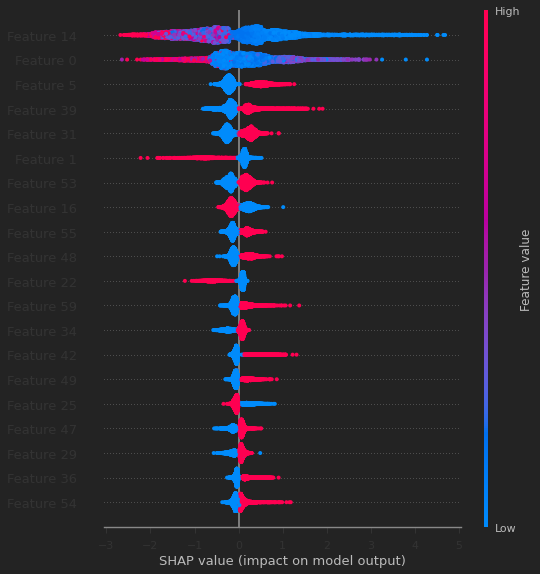

In [34]:
shap.initjs()
explainer = shap.TreeExplainer(final_model.best_estimator_.named_steps["Estimator"])
shap_values = explainer.shap_values(X_train_scaled_slice)
shap.summary_plot(shap_values, X_train_scaled_slice)

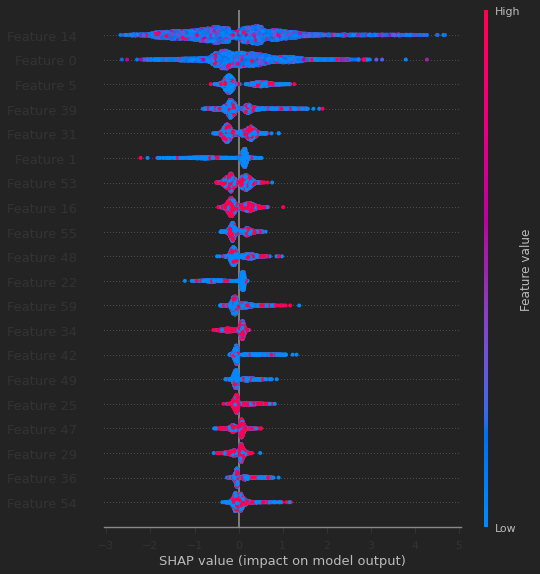

In [35]:
shap.summary_plot(shap_values, X_test_scaled_slice)

In [40]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[100], X_train_scaled_slice[100,:])
#shap.summary_plot(shap_values, X_train_scaled_slice)